$$\require{mhchem}$$       

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
from pycse import odelay
from scipy.optimize import minimize
from scipy.integrate import quad
import quantities as u
import uncertainties as un
from scipy.optimize import root
from scipy.optimize import fmin
np.set_printoptions(precision=3)  # alternate approach to printing accuracy


- Label the x/y axis of graphs (and legend if appropriate)
- Comment your code so we understand what you're doing
- 'print' your identified solutions / fitted constants with units

# Effectiveness factors (30 pt)

The following second-order gas-phase catalytic reaction is conducted in an isothermal fixed-bed reactor.
\begin{align*}
\ce{A->B}
\end{align*}
The volumetric rate constant inside the catalyst particle is 15.0 L/mol/s at 800 K.
The feed is 1,500 L/hr of pure A at 10.0 atm and 800 K.
Spherical catalyst pellets of radius 1.2 cm are used to pack the reactor.
The catalyst particles have a density of 0.9 g/cm$^3$.
The effective diffusivity of A inside the catalyst pellet is 2.06 $\times 10^{-4}$ cm$^2$/s.
There is no pressure drop.

####  Calculate the Thiele modulus at the inlet of the reactor. (6 pt)

In [13]:
D = 2.06*10**(-4) #cm2/s
rad = 1.2 #cm
a = rad/3 
k = 15 #l/mol/s
n = 2 #power law kinetics
T = 800 #K
P = 10 #atm
R = 0.082 #l.atm.K-1.mol-1
rhocat = 0.9 #g/cm3
Cas = P/(R*T) #surface concentration ~= bulk concentration at inlet conditions
phi = ((n+1)/2*(k*Cas*a**2/D))**0.5
print("The value of Thiele modulus is {0:1.4f} ".format(phi))

The value of Thiele modulus is 51.6138 


####  Calculate the reaction rate per gram of catalyst particle at the inlet of the reactor. Use the following modified form for the effective reaction rate: (4 pt)
\begin{equation}
r = -k\: c_{As}^n\frac{\eta}{\rho_{cat}}
\end{equation}

In [15]:
eta = 1/phi * (1/np.tanh(3*phi) - 1/(3*phi))
r = -k*(Cas**2) * eta /(1000*rhocat) #divide by 1000 to get cm3
print("The reaction rate per gram catalyst is",r,"mol/g.s")

The reaction rate per gram catalyst is -7.45523750822e-06 mol/g.s


#### Calculate the concentration profile of $A$ for a reactor with 50 kg of catalyst. Note that $C_A$ is varying, so the Thiele modulus and effectiveness factor will change as well. (15 pt)

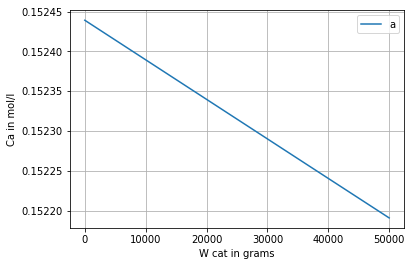

In [53]:
D = 2.06*10**(-4) #cm2/s
rad = 1.2 #cm
a = rad/3 
k = 15 #l/mol/s
n = 2 #power law kinetics
T = 800 #K
P = 10 #atm
R = 0.082 #l.atm.K-1.mol-1
rhocat = 0.9 #g/cm3

v0 = 1500 #L/hr
Fa0 = v0 * Cas  #mol/hr
Fb0 = 0.000001
F0 = [Fa0,Fb0]
Wmax = 50000 #g
Wspan = np.linspace(0,Wmax,num = 1000)
F=[Fa0,Fb0]
def PBR(F, W):
    Fa, Fb = F  # unpack the variables

    Ft = Fa + Fb 

    Pa = Fa / Ft * P
    Pb = Fb / Ft * P

    Ca = Pa/(R*T)
    Cb = Pb/(R*T)

    phi = (3./2.*(k*Ca*a**2./D))**0.5
    eta = 1/phi * (1/np.tanh(3*phi) - 1/(3*phi))

    # the stoichiometry
    r = -k*(Ca**2) * eta /(1000*rhocat) #divide by 1000 to get cm3

    ra = r
    rb = -r


    # define the 4 coupled ODES
    dFadW = ra
    dFbdW = rb

    return [dFadW, dFbdW]
a = odeint(PBR,[Fa0,0],Wspan)
plt.plot(Wspan,a[:,0]/v0)
plt.xlabel("W cat in grams")
plt.ylabel("Ca in mol/l")
plt.legend(['a'], loc='best')
plt.title("")
plt.grid()
plt.show()

#### Calculate the mass of catalyst necessary to reach 85% conversion. (5 pt)

In [60]:
D = 2.06*10**(-4) #cm2/s
rad = 1.2 #cm
a = rad/3 
k = 15 #l/mol/s
n = 2 #power law kinetics
T = 800 #K
P = 10 #atm
R = 0.082 #l.atm.K-1.mol-1
rhocat = 0.9 #g/cm3

v0 = 1500 #L/hr
Fa0 = v0 * Cas  #mol/hr
Fb0 = 0.000001
F0 = [Fa0,Fb0]
Wmax = 50000 #g
Wspan = np.linspace(0,Wmax,num = 1000)
F=[Fa0,Fb0]
def PBR(F, W):
    Fa, Fb = F  # unpack the variables

    Ft = Fa + Fb 

    Pa = Fa / Ft * P
    Pb = Fb / Ft * P

    Ca = Pa/(R*T)
    Cb = Pb/(R*T)

    phi = (3./2.*(k*Ca*a**2./D))**0.5
    eta = 1/phi * (1/np.tanh(3*phi) - 1/(3*phi))

    # the stoichiometry
    r = -k*(Ca**2) * eta /(1000*rhocat) #divide by 1000 to get cm3

    ra = r
    rb = -r


    # define the 4 coupled ODES
    dFadW = ra
    dFbdW = rb

    return [dFadW, dFbdW]

def event1(F, W):
    Fa,Fb= F
    conv = (Fa0-Fa)/Fa0
    value = abs(conv-0.85)
    isterminal = True
    direction = 0       # all zeros
    return value, isterminal, direction
x, y, te, ye, ie = odelay(PBR, F0, Wspan, [event1])
print("The value of W which gives 85% conversion is",x[-1],"grams")



The value of W which gives 85% conversion is, 50000.0 grams


# Transient, non-isothermal reactor (50 pt)

The liquid phase reactions
\begin{align*}
\ce{A->B}\\
\ce{A->C}
\end{align*}
are each first order in the concentration of A.  The feed to a nonisothermal transient CSTR contains pure A at 45 $^{\circ}$C and 5 mol/L.  We want to operate this reactor such that the selectivity to B is greater than the selectivity to C.  The following parameters apply:

| Parameter       | Value                                    | Units   |
|-----------------|------------------------------------------|---------|
| $M_t$           | 93,200                                   | g/min   |
| $\Delta H_{r1}$ | -12,000                                  | cal/mol |
| $\Delta H_{r2}$ | -15,000                                  | cal/mol |
| V               | 1,000                                    | L       |
| $Q_f$           | 100                                      | L/min   |
| $C_{pf}$        | 0.22                                     | cal/g/K |
| $k_1$           | $3.16 \times 10^{14}\exp (-12,500 [K]/T)$ | 1/min   |
| $k_2$           | $2.52 \times 10^{9}\exp (-8,500 [K]/T) $  | 1/min   |

The CSTR has a cooling bath at 50 $^{\circ}$C and a $Ua$ of 100,000 cal/min/K.  The reactor initially starts at 45 $^{\circ}$C and C$_a$=C$_b$=C$_c$=0 M. The total mass in the reactor is $V M_t / Q_f$.

#### If you want to increase selectivity in the reactor ($C_B/C_C$), should you increase or decrease the temperature in the reactor? (5 pt)

dk1/dt = -125000*(large number)
dk2/dt = -smaller number
hence in order to increase k1, we need to reduce the temperature

#### Calculate the  transient temperature and concentrations in this reactor.  You may assume the heats of reactions are constant w.r.t to temperature ( since Cpa=Cpb=Cpc, dCp=0) for the first 40 minutes. (30 pt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


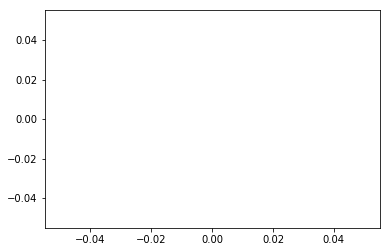

In [76]:
import numpy as np
M_t   = 93,200 # g/min   |
dHrxn1 = -12000    # cal/mol |
dHrxn2= -15000   # cal/mol |
V  = 1000   # L       |
Qf =100 # L/min   |
Cp = 0.22  # cal/g/K |
T=274
k_1 = 3.16 * (10**14) *np.exp(-12500 /T) #1/min 
k_2= 2.52 * (10**9) * np.exp(-8500 /T) #| 1/min  
T0 = 45+273
U = 100000 #cal/min/K
Tc = 50+273
Cp = Ca0 = Cb0 = Cc0  = 0
v0 = 93200
Fc0 = 0
def transient_cstr (N,t):
    Na,Nb,Nc,T = N
    
    Ca = Na/V
    Cb = Nb/V
    Cc = Nc/V
    
    Fa = Na*v0/V
    Fb = Nb*v0/V
    
   
    k1 = 3.16 * (10**14) *np.exp(-12500 /T)
    k2= 2.52 * (10**9) * np.exp(-8500 /T)
    
   
    r1 = k1*Ca
    r2 = k2*Ca
    
    ra = -r1 - r2
    rb = r1
    rc = r2
    Qdot = U*(Tc-T)
    
    dNadt = Fa0 - Fa + ra*V
    dNbdt = Fb0 - Fb + rb*V
    dNcdt = Fb0 - Fb + rb*V
    dTdt = (((Fa0*Cp+Fb0*Cp+Fc0*Cp)*(T0-T)-dHrxn1*r1*V-dHrxn2*r2*V+Qdot)/(Na*Cp + Nb*Cp + Nc*Cp))
    return [dNadt,dNbdt,dNcdt,dTdt]
tspan = np.linspace(0,40)
N0 = [Ca0*V,Cb0*V,Cc0*V,50+273]
a = odeint(transient_cstr,N0,tspan)
plt.plot(tspan,a[:,0],tspan,a[:,1],tspan,a[:,2])
plt.show()



#### Calculate the cumulative selectivity of this reactor at 40 min, defined as $C_B/C_C$, as a function of the bath temperature, from 30 $^{\circ}$C to 60 $^{\circ}$C. (10 pt)

In [ ]:
import numpy as np
M_t   = 93,200 # g/min   |
dHrxn1 = -12000    # cal/mol |
dHrxn2= -15000   # cal/mol |
V  = 1000   # L       |
Qf =100 # L/min   |
Cpf  = 0.22  # cal/g/K |
T=274
k_1 = 3.16 * (10**14) *np.exp(-12500 /T) #1/min 
k_2= 2.52 * (10**9) * np.exp(-8500 /T) #| 1/min  
T0 = 45+273
U = 100000 #cal/min/K
Tc = 50+273
Ca0 = Cb0 = Cc0  = 0

fot Tc in range(30,60):
    def transient_cstr (N,t):
        Na,Nb,Nc,T = N

        Ca = Na/V
        Cb = Nb/V
        Cc = Nc/V

        Fa = Na*v0/V
        Fb = Nb*v0/V


        k_1 = 3.16 * (10**14) *np.exp(-12500 /T)
        k_2= 2.52 * (10**9) * np.exp(-8500 /T)


        r1 = k1*Ca
        r2 = k2*Ca

        ra = -r1 - r2
        rb = r1
        rc = r2
        Qdot = U*(Tc-T)

        dNadt = Fa0 - Fa + ra*V
        dNbdt = Fb0 - Fb + rb*V
        dNcdt = Fb0 - Fb + rb*V
        dTdt = (((Fa0*Cp+Fb0*Cp+Fc0*Cp)*(T0-T)-dHrxn1*r1*V-dHrxn2*r2*V+Qdot)/(Na*Cp + Nb*Cp + Nc*Cp))
        return [dNadt,dNbdt,dTdt]
    tspan = np.linspace(0,40)
    N0 = [Ca0*V,Cb0*V,Cc0*V,50+273]
    a = odeint(transient_cstr,N0,tspan)
    sel = a[-1,1]/a[-1,2]
    print(sel)


#### Describe the profile and selectivity plots you made (a few sentences or bullets). Discuss any abnormalities you may see and why they appear. [5 pt]

Selectivity decreases with temperature

# Short answers (explain with 1-2 sentences)

#### A 5-L adiabatic, catalytic PFR has a conversion of 55% for the reaction A(g) $\rightarrow$ B(g). The inlet flow rate was cut in half, but the conversion only increased to 56%. Of the three following explanations, which one(s) may explain this phenomenon? (5 pt)
1. reaction is limited by mass transfer	
2. reaction is equilibrium limited	
3. the decrease in velocity due to the increase in moles limits the conversion	

It could be due to either of 1 or 2. 
1) All the possible sites would be filled up even when flowrate was half. So when it was doubled, it didnt make a difference as the sites would still be filled up with half the flowrate
2) The equilibrium conversion could lie closer to 56% so increasing the retention time would not make a difference

#### The concentration of A vs. distance in a PFR is shown for the first-order, exothermic reaction A $\rightarrow$ B. One curve represents an isothermal reactor, and the other an adiabatic reactor. Which statement is correct? (5 pt)
- 1 is adiabatic, 2 is isothermal	
- 1 is isothermal, 2 is adiabatic	
- Either could be adiabatic or isothermal	

![img](./20110902212632130d3e0582858752caea2af4d16c43da.gif)


Option 2:
In plot 2,As reaction proceeds towards right, the temperature rises, pushing down the equilibrium conversion. Hence the rate goes to near 0
In plot 1, as heat is being continuosuly removed, we can achieve even full conversion as the temperature remains the same.

#### At a fixed O$_2$ pressure for the reaction:  (5 pt)

$\ce{CO + 1/2O2 -> CO2}$

the CO pressure increased from zero to a large number. If the reaction follows the Langmuir-Hinshelwood mechanism, what happens to the rate of reaction?
- goes through a maximum	
- goes through a minimum	
- increases slowly at first, then more rapidly	
- increases quickly at first, then more slowly	

option D:
    Initially, due to high CO concentration, the rate rises rapidly. As the active sites get filled up, the reaction rate drops down.

#### A plot of rate versus distance along an adiabatic PFR for a 1st-order reaction is shown below (original). Which curve (A,B,C, D) will the plot look like if the feed temperature were increased? (5 pt)
![img](./2011090310020582250ee1b17678c159deb817f8252880.gif)


It will be more like plot A. Initially, due to high temperature, we get high kinetics with high temperature. However, the equilibrium is achieved faster and hence the rate drops to 0 very fast.